<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/bonespect_train_whole_spine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import numpy as np
import cv2, os, copy, shutil
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim


In [2]:
inputDataPath = sorted(glob("/content/drive/MyDrive/Bone_SPECT/data/norInputData/*.npy"))
labelDataPath = sorted(glob("/content/drive/MyDrive/Bone_SPECT/data/norLabelData/*.npy"))

In [3]:
totalNum = len(inputDataPath)

In [4]:
for i in range(totalNum):
    tempInput = inputDataPath[i].split("/")[-1][-22:-14]
    tempLabel = labelDataPath[i].split("/")[-1][-22:-14]
    if tempInput != tempLabel:
        print(i)
    else:
        continue

In [5]:
inputObj = []
labelObj = []

for i in range(totalNum):
    tempInputObj = np.load(inputDataPath[i])
    tempInputObj = np.array(tempInputObj, dtype=np.float64)
    tempLabelObj = np.load(labelDataPath[i])
    tempLabelObj = np.array(tempLabelObj, dtype=np.uint16)
    inputObj.append(tempInputObj)
    labelObj.append(tempLabelObj)

In [6]:
def padObj(srcObj, targetSize):
    '''
    inputs: source array(images, labels), and wanted height size(int, ex: 1024))
    return: destinate array
    '''
    io_x, ioy = np.shape(srcObj)
    if io_x != targetSize:
        diffIOx = targetSize - io_x
        zeroPadding = np.zeros((diffIOx,256))
        dstObj = np.vstack([srcObj,zeroPadding])
    else:
        dstObj = srcObj
    return dstObj

In [7]:
MAX_SIZE = 512

In [8]:
if MAX_SIZE == 1024:
    train_imgs = []
    train_lbls = []
    for i in range(totalNum):
        train_imgs.append(padObj(inputObj[i],MAX_SIZE))
        train_lbls.append(padObj(labelObj[i],MAX_SIZE))
elif MAX_SIZE == 512:
    train_imgs = []
    train_lbls = []
    for i in range(totalNum):
        train_imgs.append(inputObj[i][:512,:])
        train_lbls.append(labelObj[i][:512,:])

In [9]:
temp_train_imgs = np.array(train_imgs)
temp_train_lbls = np.array(train_lbls)

In [ ]:
# 0: BG, 1: C, 2: T, 3: L
temp_train_lbls = np.where((temp_train_lbls>=2)&(temp_train_lbls<14),2,temp_train_lbls)
temp_train_lbls[temp_train_lbls>13]=3

In [10]:
# whole spine
temp_train_lbls[temp_train_lbls >= 1] = 1

In [11]:
split_num = 800

In [12]:
train_imgs = temp_train_imgs[:split_num,...]
valid_imgs = temp_train_imgs[split_num:,...]
train_msks = temp_train_lbls[:split_num,...]
valid_msks = temp_train_lbls[split_num:,...]

In [13]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

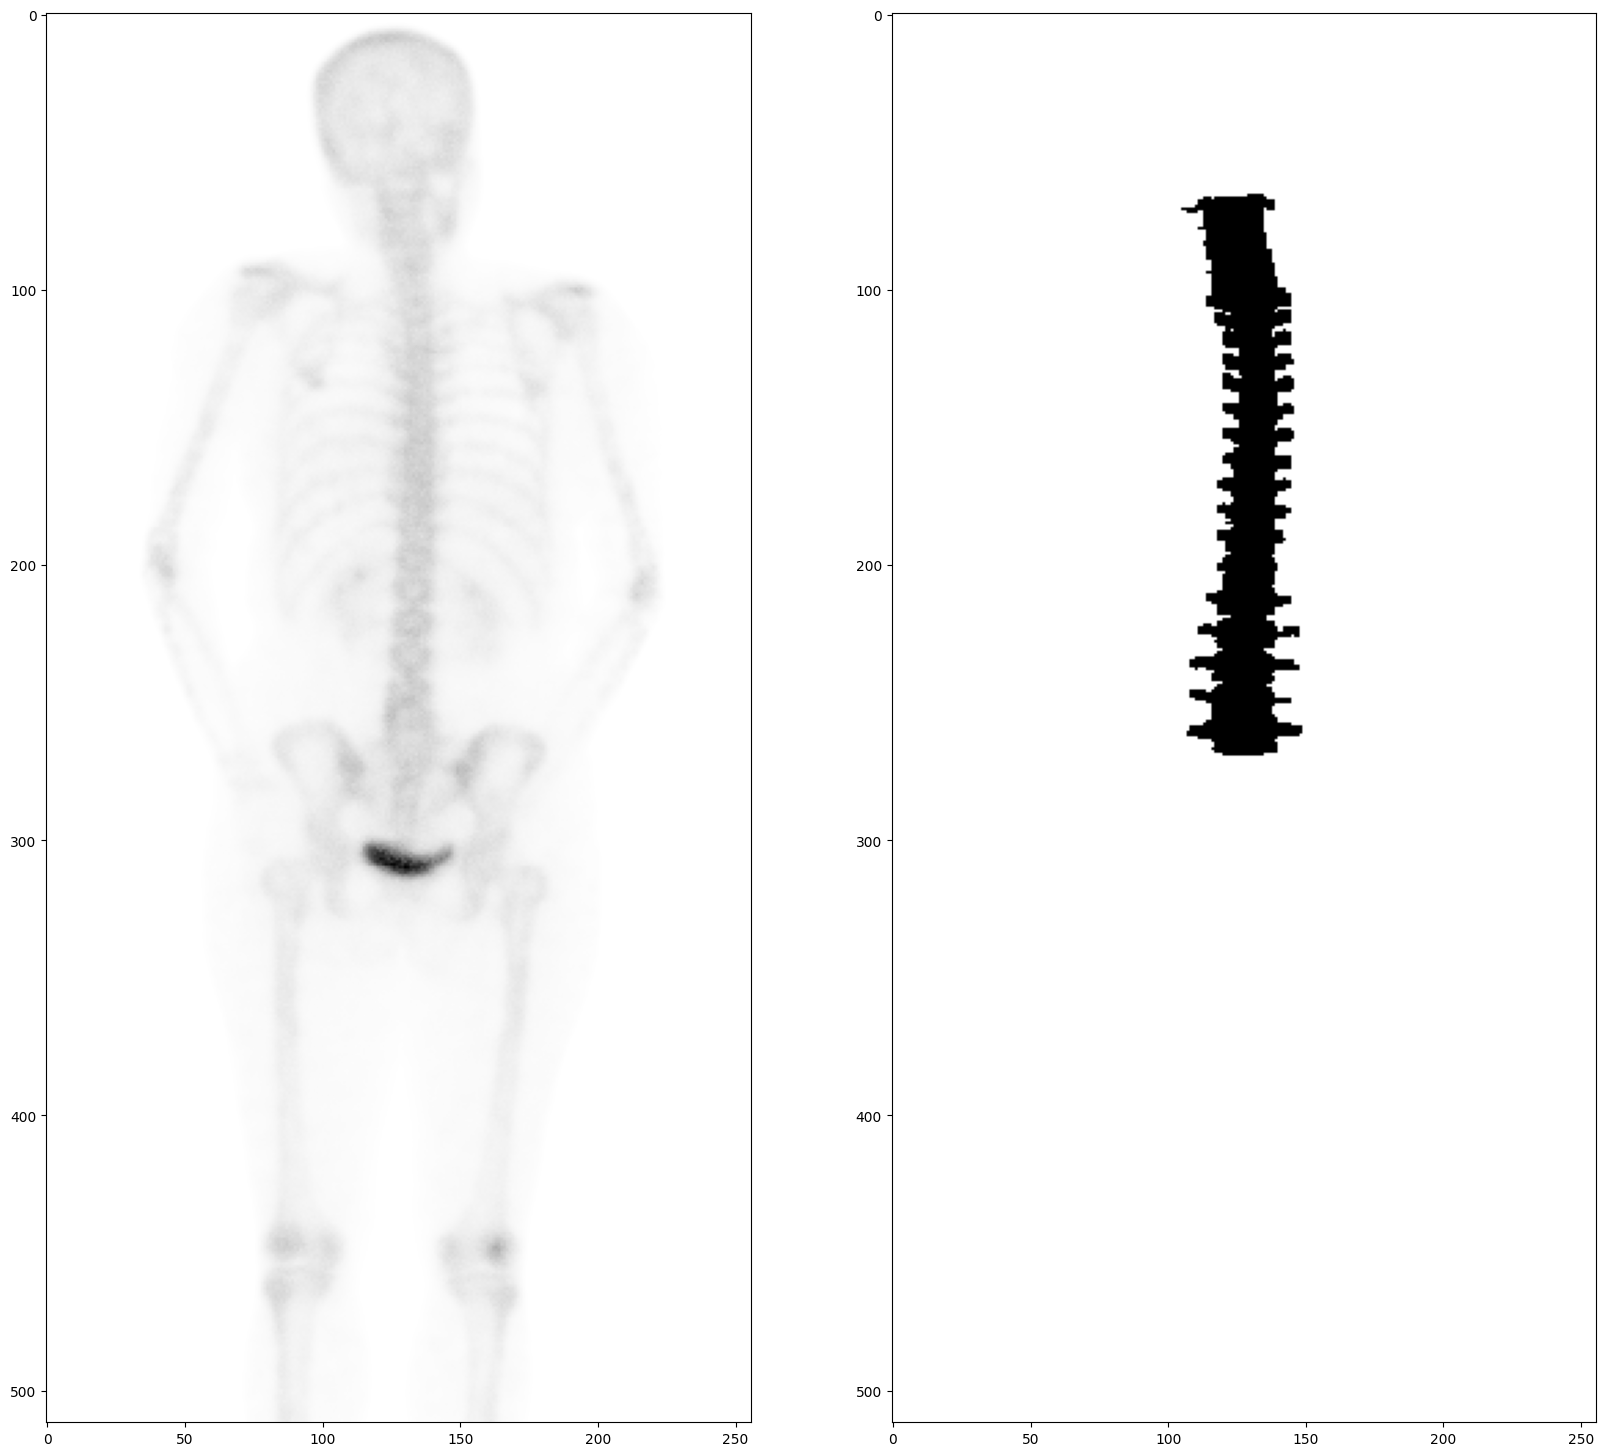

In [14]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num]*13, cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray_r')

# Construct the model

In [28]:
inputs = Input((MAX_SIZE, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [29]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [30]:
initial_learning_rate = 9e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Bone_SPECT/models/mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [31]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [24]:
model_history = model.fit(train_imgs, train_msks, batch_size=10, epochs=200, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/200
80/80 [==============================] - ETA: 0s - loss: 0.8053 - binary_crossentropy: 0.6785 - generalized_dice_coefficient: 0.0679
Epoch 1: val_loss improved from inf to 0.80929, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_1.h5
80/80 [==============================] - 16s 124ms/step - loss: 0.8053 - binary_crossentropy: 0.6785 - generalized_dice_coefficient: 0.0679 - val_loss: 0.8093 - val_binary_crossentropy: 0.6878 - val_generalized_dice_coefficient: 0.0692
Epoch 2/200
80/80 [==============================] - ETA: 0s - loss: 0.7938 - binary_crossentropy: 0.6490 - generalized_dice_coefficient: 0.0614
Epoch 2: val_loss improved from 0.80929 to 0.79585, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_2.h5
80/80 [==============================] - 9s 117ms/step - loss: 0.7938 - binary_crossentropy: 0.6490 - generalized_dice_coefficient: 0.0614 - val_loss: 0.7959 - val_binary_crossentropy: 0.6562 - val_generalized_dice_coefficient: 0.0645

In [27]:
del model

In [25]:
import pickle
with open("/content/drive/MyDrive/Bone_SPECT/training_historyWS.pkl", 'wb') as file:
    pickle.dump(model_history.history, file)

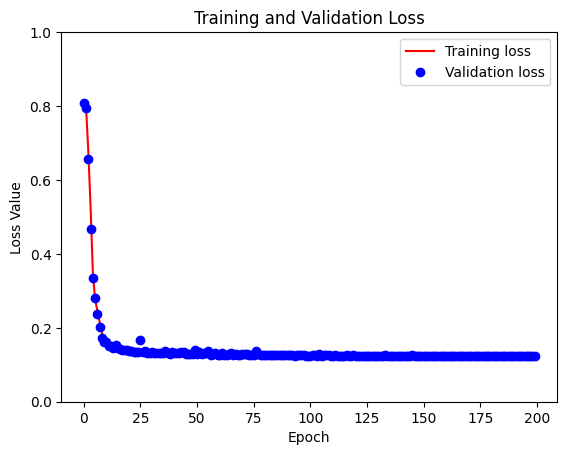

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()